https://www.kaggle.com/crowdflower/twitter-airline-sentiment

#### Import modules

In [1]:
%matplotlib inline

In [3]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from tqdm import tqdm_notebook

import nbimporter
from tweet_sentiment_analysis_2_preprocess import clean_text, tokenize, stop_words

from time import time
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(0)

Importing Jupyter notebook from tweet_sentiment_analysis_2_preprocess.ipynb


In [4]:
tweets=pd.read_csv('Tweets_preprocess.csv', index_col=0)

In [5]:
general_stop, customized_stop=stop_words(tweets)

In [6]:
labels=['positive', 'neutral', 'negative']

# 3. Model

## 3.1 Fit into a baseline model

### 3.1.1 Split into train, cv and test

In [7]:
def data_split(df, seed=seed):
    train, test=train_test_split(df, test_size=.1)
    return train, test

In [8]:
def get_Y(tweets_split):
    train, test=tweets_split
    train_Y=train.pop('sentiment')
    test_Y=test.pop('sentiment')
    return train_Y, test_Y

In [9]:
tweets_split=data_split(tweets)

In [10]:
train_Y, test_Y=get_Y(tweets_split)

In [11]:
print("Train set has total", len(train_Y))
print("Test set has total", len(test_Y))

Train set has total 13176
Test set has total 1464


In [12]:
df=pd.DataFrame({'train_Y': train_Y.value_counts()/train_Y.shape[0],
                 'test_Y': test_Y.value_counts()/test_Y.shape[0]})
df

,train_Y,test_Y
negative,0.627125,0.625000
neutral,0.210534,0.221995
positive,0.162341,0.153005


Calculate null accuracy: accuracy that could be achieved by always predicting the most frequent class

A well-performed classifier is expected to get a better accuracy than null accuracy

In [13]:
def calculate_null_accuracy(test_Y):
    return max(test_Y.value_counts()/test_Y.shape[0])

In [14]:
null_accuracy=calculate_null_accuracy(test_Y)
print('The null accuracy is '+str(null_accuracy))

The null accuracy is 0.625


### 3.1.2 Vectorize the tokens

In [15]:
def vectorize(vectorizer=CountVectorizer(), 
              tweets_split=tweets_split, 
              max_tokens=None, 
              more_features=False):
    
    train, test=tweets_split
    
    vectorizer.set_params(max_features=max_tokens)
    train_X=vectorizer.fit_transform(train['text_clean'])
    test_X=vectorizer.transform(test['text_clean'])
    tokens=pd.DataFrame({'token': vectorizer.get_feature_names()})
    
    if more_features:
        f=lambda x: x[x.columns[~x.columns.isin(['text', 'text_clean'])]]

        train_X=pd.DataFrame(train_X.todense(), 
                             columns=tokens['token'].map(lambda x: 'token_'+x)
                            ).set_index(train.index)
        train_X=train_X.join(f(train))
        
        test_X=pd.DataFrame(test_X.todense(), 
                            columns=tokens['token'].map(lambda x: 'token_'+x)
                           ).set_index(test.index)
        test_X=test_X.join(f(test))
    
    return tokens, train_X, test_X

Vectorize the uniq words of training set using just count vectorizer and union with the other features

In [16]:
tokens, train_X, test_X=vectorize(more_features=True)

In [17]:
print('token # of train set:', tokens.shape[0])

token # of train set: 10686


### 3.1.3 Build baseline model

I'm using logistic regression as the baseline model. 

Since our data is skewed to 'negative', I'll use f1_score as the main evaluating metric when the accuracy is better than guessing.

In [18]:
def model(clf, train_X, train_Y, test_X, test_Y):
    start=time()
    clf.fit(train_X, train_Y)
    pred=clf.predict(test_X)
    end=time()
    accuracy=accuracy_score(test_Y, pred)
    precision, recall, f1, _=precision_recall_fscore_support(test_Y, pred, 
                                         labels=labels,
                                         average='weighted', 
                                         warn_for=tuple())
    return pred, {clf.__class__.__name__:
            {'better_than_null': accuracy>null_accuracy, 
            'accuracy': accuracy, 
            'f1_score': f1, 
            'precision': precision,
            'recall': recall,
            'running_time': end-start}}

In [19]:
def summarize_model(clf, train_X, train_Y, test_X, test_Y, show_confusion=True):
    pred, summary=model(clf, train_X, train_Y, test_X, test_Y)
    display(pd.DataFrame.from_dict(summary).T)
    if show_confusion:
        confusion=confusion_matrix(test_Y, pred, labels=labels)
        confusion = pd.DataFrame(confusion, index=labels,
                                 columns=['predicted_'+l for l in labels])
        display(confusion)

In [20]:
dummy_model = DummyClassifier(strategy = 'most_frequent')
summarize_model(dummy_model, train_X, train_Y, test_X, test_Y)

,accuracy,better_than_null,f1_score,precision,recall,running_time
DummyClassifier,0.625,False,0.480769,0.390625,0.625,0.0116279


,predicted_positive,predicted_neutral,predicted_negative
positive,0,0,224
neutral,0,0,325
negative,0,0,915


In [21]:
clf=LogisticRegression(multi_class='multinomial', solver='newton-cg')
summarize_model(clf, train_X, train_Y, test_X, test_Y)

,accuracy,better_than_null,f1_score,precision,recall,running_time
LogisticRegression,0.797131,True,0.795599,0.794633,0.797131,109.331


,predicted_positive,predicted_neutral,predicted_negative
positive,159,23,42
neutral,26,204,95
negative,24,87,804


Without feature selection, the baseline model logistic regression runs more than 400 seconds and reach 0.79 f1 score and accuracy, much better than guessing the most frequent class.

## 3.2 Define approach based on baseline model

Use a cross-validation method for comparing. Considering the computation speed, I'll compare the model performance on selected tokens (less than 500).

In [22]:
clf=LogisticRegressionCV(cv=3, multi_class='multinomial', solver='newton-cg', max_iter=200)

### 3.2.1 Compare text cleaning options: stem and stop

In [23]:
def compare_clean_text_options(clf, tweets, metric='f1_score'):
    clf_name=clf.__class__.__name__
    d={}
    for k, stop in [('general', general_stop), 
                    ('customized', customized_stop), 
                    ('none', None)]:
        for stem in [True, False]:
            tag='stem_'+str(stem)+'_stop_'+k
            print(tag)
            tweets, _, _=tokenize(tweets, stop=stop, stem=stem)
            d[tag]={}
            for f in tqdm_notebook(range(50, 501, 50)):
                tweets_split=data_split(tweets, seed=seed)
                train_Y, test_Y=get_Y(tweets_split)
                _, train_X, test_X=vectorize(vectorizer=CountVectorizer(), 
                                             tweets_split=tweets_split, 
                                             max_tokens=f,
                                             more_features=False)
                _, summary=model(clf, train_X, train_Y, test_X, test_Y)
                d[tag][f]=summary[clf_name][metric]
    pd.DataFrame(d).plot(kind='line', figsize=(10,10))
    plt.xlabel('max_tokens')
    plt.ylabel(metric)
    plt.title('Compare text cleaning options - '+clf_name)
    plt.show()
    return d

stem_True_stop_general



stem_False_stop_general



stem_True_stop_customized



stem_False_stop_customized



stem_True_stop_none



stem_False_stop_none


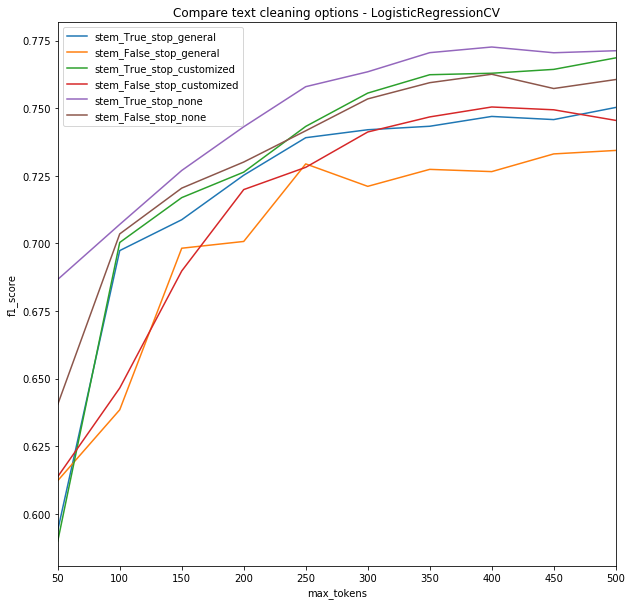

In [24]:
_=compare_clean_text_options(clf, tweets)

From the figure above, the option "stem_True_stop_none" performs best overall. So I'll use this option for the following steps.

### 3.2.2 Tfidf vs Count

In [25]:
def compare_vectorizer_options(clf, tweets, metric='f1_score'):
    clf_name=clf.__class__.__name__
    d={}
    for vectorizer in [CountVectorizer(), TfidfVectorizer()]:
        v_name=vectorizer.__class__.__name__
        print(v_name)
        d[v_name]={}
        for f in tqdm_notebook(range(50, 501, 50)):
            tweets_split=data_split(tweets)
            train_Y, test_Y=get_Y(tweets_split)
            _, train_X, test_X=vectorize(vectorizer=vectorizer, 
                                        tweets_split=tweets_split, 
                                        max_tokens=f,
                                        more_features=False)
            _, summary=model(clf, train_X, train_Y, test_X, test_Y)
            d[v_name][f]=summary[clf_name][metric]
    pd.DataFrame(d).plot(kind='line')
    plt.xlabel('max_tokens')
    plt.ylabel(metric)
    plt.title('Compare vectorizer options - '+clf_name)
    plt.show()
    return d

CountVectorizer



TfidfVectorizer


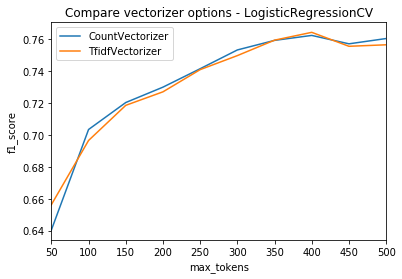

In [26]:
_=compare_vectorizer_options(clf, tweets)

CountVectorizer



TfidfVectorizer


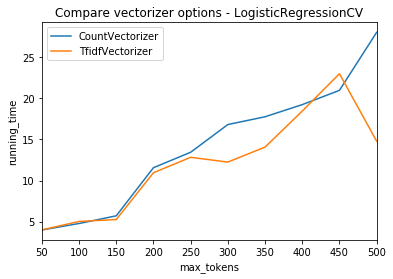

In [27]:
_=compare_vectorizer_options(clf, tweets, metric='running_time')

For logistic regression above, Tfidf vetorizer performs better f1 score overall.

Since Tdidf Vectorizer is normalization of Count Vectorizer (required by some classifier like svm) and it generally runs faster, I'll continue using Tfidf vectorizer

### 3.3.3 Features selection on token, meta and other features

Refresh data using the options determined by the comparisons above

In [28]:
tweets, _, _=tokenize(tweets, stem=True, stop=None)
tweets_split=data_split(tweets)
train_Y, test_Y=get_Y(tweets_split)
tokens, train_X, test_X=vectorize(vectorizer=TfidfVectorizer(), 
                                  tweets_split=tweets_split, 
                                  more_features=True)

Pick the most 50 informative features in the data

In [29]:
def chi_squared_select(k, train_X, train_Y):
    if k>train_X.shape[1]:
        k='all'
    chi2_selector=SelectKBest(chi2, k)
    le = LabelEncoder()
    chi2_selector.fit(train_X, le.fit_transform(train_Y))
    return chi2_selector

In [30]:
chi2_selector=chi_squared_select(50, train_X, train_Y)

In [31]:
train_X.columns[chi2_selector.get_support()]

Index(['token_amaz', 'token_appreci', 'token_awesom', 'token_bag',
       'token_been', 'token_best', 'token_call', 'token_cancel',
       'token_custom', 'token_delay', 'token_destinationdragon', 'token_dm',
       'token_excel', 'token_eye', 'token_fantast', 'token_fleek',
       'token_fleet', 'token_fold', 'token_follow', 'token_good',
       'token_great', 'token_hand', 'token_heart', 'token_hold', 'token_hour',
       'token_hr', 'token_kudo', 'token_love', 'token_much', 'token_no',
       'token_not', 'token_quick', 'token_rock', 'token_smile', 'token_thank',
       'token_wait', 'token_worst', 'token_you', 'tweet_airline_American',
       'tweet_airline_Delta', 'tweet_airline_Southwest',
       'tweet_airline_US Airways', 'tweet_airline_United',
       'tweet_airline_Virgin America', 'meta_score', 'meta_len',
       'meta_count_space', 'meta_count_!', 'meta_count_?',
       'meta_word_per_sent'],
      dtype='object')

Compare the performance with different choice of features (from 50 to 500)

In [33]:
def feature_selection(clf, train_X, train_Y, test_X, test_Y, metric='f1_score'):
    clf_name=clf.__class__.__name__
    d={clf_name:{}}
    for f in tqdm_notebook(range(50, 501, 50)):
        print('select', f,'best features')
        chi2_selector=chi_squared_select(f, train_X, train_Y)
        train_X_kbest=chi2_selector.transform(train_X)
        test_X_kbest=chi2_selector.transform(test_X)
        _, summary=model(clf, train_X_kbest, train_Y, test_X_kbest, test_Y)
        d[clf_name][f]=summary[clf_name][metric]
    pd.DataFrame(d).plot(kind='line')
    plt.xlabel('max_features')
    plt.ylabel(metric)
    plt.title('Compare vectorizer options - '+clf_name)
    plt.show()
    return d

select 50 best features
select 100 best features
select 150 best features
select 200 best features
select 250 best features
select 300 best features
select 350 best features
select 400 best features
select 450 best features
select 500 best features



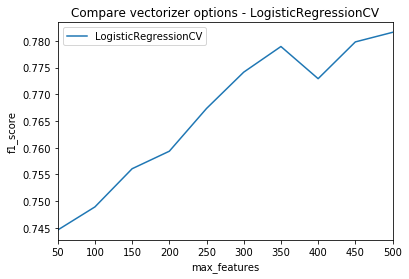

In [34]:
_=feature_selection(clf, train_X, train_Y, test_X, test_Y, metric='f1_score')

Naturally the more features we selected, the better f1_score the model will gain. As mentioned, considering the computation speed, I'll choose the at most top 200 informative features for future steps.

## 3.4 Tune hyper-parameters

In [35]:
clf=GridSearchCV(LogisticRegression(multi_class='multinomial', max_iter=1000), 
                 {'solver':['newton-cg', 'lbfgs', 'sag', 'saga'], 
                  'C':[0.5, 0.1, 1, 5, 10]}, 
                 cv=3)

In [37]:
chi2_selector=chi_squared_select(200, train_X, train_Y)
summarize_model(clf, 
                chi2_selector.transform(train_X), train_Y, 
                chi2_selector.transform(test_X), test_Y)

,accuracy,better_than_null,f1_score,precision,recall,running_time
GridSearchCV,0.765027,True,0.757415,0.75577,0.765027,78.2616


,predicted_positive,predicted_neutral,predicted_negative
positive,141,26,57
neutral,26,165,134
negative,25,76,814


In [38]:
clf.get_params()

{'cv': 3,
 'error_score': 'raise-deprecating',
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__max_iter': 1000,
 'estimator__multi_class': 'multinomial',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'warn',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=1000, multi_class='multinomial',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'fit_params': None,
 'iid': 'warn',
 'n_jobs': None,
 'param_grid': {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
  'C': [0.5, 0.1, 1, 5, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': 'warn',
 'sco

## 3.5. Evaluation and Comparison

In [39]:
def model_comparator(classifiers, train_X, train_Y, test_X, test_Y, k=100):
    results={}
    chi2_selector=chi_squared_select(k, train_X, train_Y)
    train_X_kbest=chi2_selector.transform(train_X)
    test_X_kbest=chi2_selector.transform(test_X)
    for clf in tqdm_notebook(classifiers):
        clf_name=clf['model'].__class__.__name__
        print('Grid search for', clf_name)
        clf=GridSearchCV(clf['model'], clf['params'], cv=3)
        _,result=model(clf, train_X_kbest, train_Y, test_X_kbest, test_Y)
        results[clf_name]=result['GridSearchCV']
    return pd.DataFrame.from_dict(results, orient='index')

In [40]:
classifiers = [
    {'model': LogisticRegression(multi_class='multinomial', max_iter=1000),
     'params': {'solver':['newton-cg', 'lbfgs', 'sag', 'saga'], 
                'C':[0.5, 0.1, 1, 5, 10]}},
    {'model': SVC(), 
     'params':[{'kernel':['linear'], 'C':[1, 10, 100, 1000], 'gamma':['auto']},
               {'kernel':['rbf'], 'C':[1, 10, 100, 1000], 'gamma':[0.001, 0.0001]}]},
    {'model': DecisionTreeClassifier(), 
     'params': {}},
    {'model': RandomForestClassifier(),
     'params': {'n_estimators': [10, 50, 100, 200]}},
    {'model': GradientBoostingClassifier(),
     'params': {'n_estimators': [10, 50, 100, 200], 
                'learning_rate': [0.05, 0.01, 0.1]}},
    {'model': KNeighborsClassifier(100),
     'params': {'n_neighbors':[50, 100, 200, 500, 1000]}},
    ]

In [41]:
comparator=model_comparator(classifiers, train_X, train_Y, test_X, test_Y)

Grid search for LogisticRegression
Grid search for SVC
Grid search for DecisionTreeClassifier
Grid search for RandomForestClassifier
Grid search for GradientBoostingClassifier
Grid search for KNeighborsClassifier



In [42]:
comparator.sort_values(by=['f1_score'])

,better_than_null,accuracy,f1_score,precision,recall,running_time
KNeighborsClassifier,True,0.687842,0.654790,0.708497,0.687842,299.258087
DecisionTreeClassifier,True,0.666667,0.669325,0.672540,0.666667,0.772930
SVC,True,0.757514,0.747686,0.746218,0.757514,648.387987
LogisticRegression,True,0.758197,0.748044,0.746041,0.758197,47.039909
RandomForestClassifier,True,0.762978,0.750692,0.752767,0.762978,22.229790
GradientBoostingClassifier,True,0.771175,0.761543,0.760706,0.771175,312.023936


In [43]:
comparator=model_comparator(classifiers, train_X, train_Y, test_X, test_Y, k=300)
comparator.sort_values(by=['f1_score'])

Grid search for LogisticRegression
Grid search for SVC
Grid search for DecisionTreeClassifier
Grid search for RandomForestClassifier
Grid search for GradientBoostingClassifier
Grid search for KNeighborsClassifier



,better_than_null,accuracy,f1_score,precision,recall,running_time
KNeighborsClassifier,True,0.672131,0.614400,0.708346,0.672131,864.997084
DecisionTreeClassifier,True,0.662568,0.665027,0.667885,0.662568,2.202787
RandomForestClassifier,True,0.774590,0.760851,0.765927,0.774590,36.217336
GradientBoostingClassifier,True,0.771175,0.762080,0.761732,0.771175,1128.498114
SVC,True,0.775956,0.770097,0.767933,0.775956,1782.399961
LogisticRegression,True,0.780055,0.773321,0.771993,0.780055,112.874186


After grid search of hyper parameters, we can find the comparison above. With top 100 informative features selected, Gradient boosting worked a little bit better than logistic regression (f-1 score and accuracy), but it's much slower. 

## 3.6 Review my work

What kind of tweets are classified in wrong class? Let's go back to logistic regression (grid search cv) I built earilier:

In [45]:
chi2_selector=chi_squared_select(200, train_X, train_Y)
pred,result=model(clf, 
                chi2_selector.transform(train_X), train_Y, 
                chi2_selector.transform(test_X), test_Y)

In [46]:
confusion=confusion_matrix(test_Y, pred, labels=labels)
confusion = pd.DataFrame(confusion, index=labels,
                         columns=['predicted_'+l for l in labels])
confusion

,predicted_positive,predicted_neutral,predicted_negative
positive,141,26,57
neutral,26,165,134
negative,25,76,814


The confusion matrix above implies the model is doing worst on distinguise neutral and negative tweets: they are more predicted as negtive. Also, among the predicted neutral tweets, a large part of them are actually negative. 

Let's look at some examples of the misclassified tweets:

In [47]:
df=pd.DataFrame({'pred': pred, 'actual':test_Y})

'neutral' tweets misclassified to 'negative':

In [48]:
df_neg=df[df['pred']=='negative']
tweets.iloc[df_neg[df_neg['actual']=='neutral'].index]['text'].tolist()[:10]

['@united we have developers flying down tmrw morn. w/45 min layover, there is an earlier flight to have 1.5hr layover, can move them up?',
 '@united your announcement for pre boarding only addresses mobility. My disability requires me to travel with a lot of stuff. Do I preboard?',
 '@SouthwestAir I will not have my passport in time for my trip. Could I still fly with photo ID? #thingsishouldknow #ifeeldumb',
 '@AmericanAir u r horrible.went online to Cancelled Flight flight-no button-4that.Called CS &amp;wait time 40 mins&amp;put in my #.800#called&amp;it hungupNOHELP',
 '@united Hi, booked a flight yesterday and received an email w/ confirmation number but today I got this error "no active flight segments"',
 '@SouthwestAir but if my bag makes it with me to Greenville tonight then all is forgiven. #HighHopes',
 "@USAirways It's 838. We boarded and we are waiting now to take off, hopefully.",
 '@AmericanAir you set a schedule try and keep it !!! #AAALWAYSLate Flight',
 '@SouthwestAir

'negative' tweets misclassified to 'neutral':

In [49]:
df_neu=df[df['pred']=='neutral']
tweets.iloc[df_neg[df_neg['actual']=='negative'].index]['text'].tolist()[:10]

["@AmericanAir In car gng to DFW. Pulled over 1hr ago - very icy roads. On-hold with AA since 1hr. Can't reach arpt for AA2450. Wat 2 do?",
 '@AmericanAir after all, the plane didn’t land in identical or worse) conditions at GRK according to METARs.',
 "@SouthwestAir can't believe how many paying customers you left high and dry with no reason for flight Cancelled Flightlations Monday out of BDL! Wow.",
 '@USAirways I can legitimately say that I would have rather driven cross country than flown on US Airways.',
 '@USAirways @husainhaqqani Mr. Husain u shld protest as well when one of ur party member Rehman Malik delayed a PIA flight for hours..???',
 "@USAirways not likely, flightaware says plane is still in Durango and hasn't departed.",
 "@AmericanAir they don't even give an option to hold.. Just say lines are busy Plz try Late Flightr",
 '@USAirways it is really embarrassing when asking for complimentary drink/snack detailed here: https://t.co/9zA6xb1h89 &amp; being argued with.',
 '

Although I have tried multiple classifiers,  best accuracy and f1 score are still around 0.75. How can I improve it? Here are my thoughts:

1. Select more features: At the beginning, logistic regression has about 0.79 f1 score when using all features. But since I limited features to 100-200 considering computation speed, which might be too few for the models are not well fit the data. 
2. Have another workaround on the tokens and build their weight more accurately
